# **REVIEW PREDICTION USING NAIVE BAYES CLASSIFIER**

**GROUP MEMBERS :**

Parvathy G Pillai [AM.EN.U4AIE21150]

S Anand [AM.EN.U4AIE21155]

**LOADING AND CHECKING DATA**

In [ ]:
!pip install scikit-plot  #plotting graphs and charts
import numpy as np        #calculations on matrices
import pandas as pd       #importing dataset & doing other ops on dataset
import matplotlib.pyplot as plt   #plot graphs
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
import seaborn as sn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Reviews.csv')
df.shape

(568454, 10)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**DATA PREPROCESSING**

Segregating data as positive and negative


In [ ]:
# Here we are replacing review score 1,2 as negative and 4,5 as a positive. we are skipping review score 3 considering it as a neutral.
def partition(x):
    if int(x)<3:
        return 'negative'
    return 'positive'

actualScore = df['Score']
positiveNegative = actualScore.map(partition)
df['Score'] = positiveNegative

Sorting data for time based splitting for model train and test dataset

(118761, 10)


<Axes: >

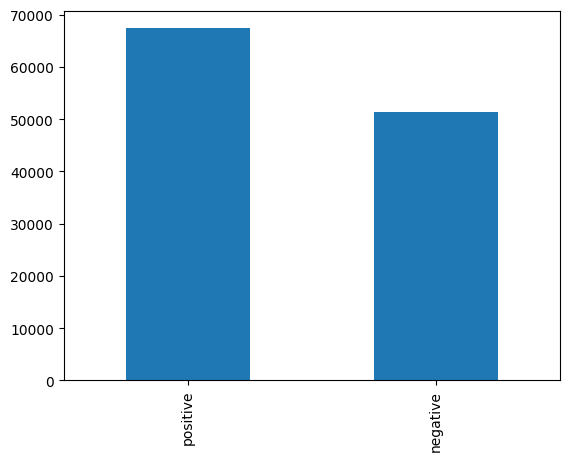

In [ ]:
import datetime

df["Time"] = df["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S')) #Converting time in dataset to a readable format

sortedData = df.sort_values('ProductId',axis=0,kind="quicksort", ascending=True) #Sorting df using productid
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False) #Dropping dupes based on a combination of columns: "UserId," "ProfileName," "Time," and "Text." Only the first occurrence is kept

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
#Rows with HelpfulnessNumerator greater than HelpfulnessDenominator are removed
#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'positive']
finalp = finalp.sample(frac=0.2,random_state=1) #0.055

finaln = final[final.Score == 'negative']
finaln = finaln.sample(frac=0.9,random_state=1) #0.25

final = pd.concat([finalp,finaln],axis=0)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

print(final.shape)
final['Score'].value_counts().plot(kind='bar')

Removing Stop-words

Remove any punctuations or limited set of special characters like , or . or # etc.

Snowball Stemming the word

Convert the word to lowercase

In [ ]:
!pip install nltk #natural language processing tasks
import re #text cleaning
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') #snowball stemming the words - running,runner,ran all have same stem:run
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Building function to find optimal Alpha for Naive Bayes**

In [ ]:
from sklearn.model_selection import train_test_split

def find_optimal_k(X_train,y_train, myList):  #Used to find the optimal value of the hyperparameter alpha for a Naive Bayes classifier

    # empty list that will hold scores
    scores = []

    # split the training data set into train and test
    X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.3)

    for i in myList:
        nb = MultinomialNB(alpha = i) #model with each of the alpha values in the list
        model = nb.fit(X_tr, y_tr) #trains the model with the selected alpha value

        # predict the response on the training dataset
        pred = model.predict(X_cv)

        # evaluate accuracy of the prediction using selected alpha value
        acc = accuracy_score(y_cv, pred, normalize=True)
        scores.append(acc)

    # changing to misclassification error
    MSE = [1 - x for x in scores]

    # determining best alpha
    optimal_alpha = myList[MSE.index(min(MSE))]#it selects the alpha from the original list myList that resulted in the minimum misclassification error during the loop over different alpha values
    print('\nThe optimal alpha is ', optimal_alpha)


    plt.figure(figsize=(10,6))
    plt.plot(myList,MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. alpha Value')
    plt.xlabel('alpha')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))

    return optimal_alpha

**APPLYING NAIVE BAYES WITH BAG OF WORDS**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer#This line imports the CountVectorizer class from the sklearn.feature_extraction.text module. CountVectorizer is a tool in scikit-learn used for converting a collection of text documents to a matrix of token counts.

#count_vect = CountVectorizer(ngram_range=(1,2) )
count_vect = CountVectorizer()#This line creates an instance of the CountVectorizer class. By default, it will tokenize the input text and convert it into a bag-of-words representation, where each word is represented by a unique integer.

final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)

from sklearn.preprocessing import StandardScaler# The StandardScaler is used for standardizing bow.

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )
# The with_mean=False argument indicates that the data is sparse, and it avoids centering the sparse data, as it can be computationally expensive.

Splitting Data into Train and Test based on the timestamp of review



In [ ]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
##In this code snippet, the dataset is split into training and testing sets based on the already sorted data by timestamp. The first 70% of the data is used for training, and the remaining 30% is used for testing.
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


X = final_bow_np  #Bag of words created from the cleaned sentences
y = final['Score'] #score taken from the final dataframe

X_train =  final_bow_np[:math.ceil(len(final)*.5)]#X_train is assigned the first 70% of rows from final_bow_np.
X_test = final_bow_np[math.ceil(len(final)*.5):]#X_test is assigned the remaining 30% of rows from final_bow_np.
y_train = y[:math.ceil(len(final)*.5)]#y_train is assigned the first 70% of labels from y.
y_test =  y[math.ceil(len(final)*.5):]  #The usage of *.7 in the code is a way to split the dataset into training and testing sets based on a percentage.

Finding Optimal alpha Cross validation




The optimal alpha is  0.00076
the misclassification error for each k value is :  [0.278 0.278 0.278 0.278 0.278 0.278 0.278 0.278 0.278 0.278 0.278 0.278
 0.278 0.278 0.278 0.278 0.278 0.278 0.278 0.278]
0.00076


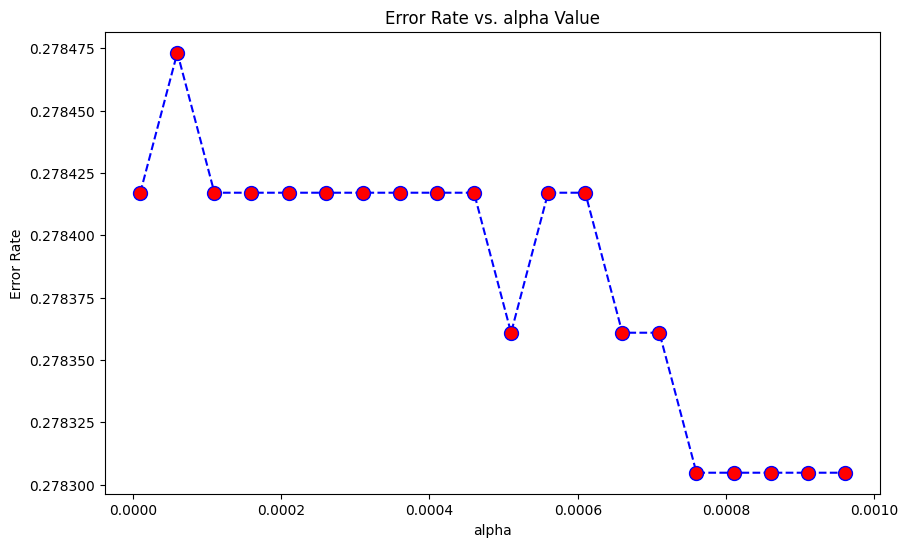

In [ ]:
from sklearn.naive_bayes import MultinomialNB

myList = np.arange(0.00001, 0.001, 0.00005) #list(range(1,200))
optimal_alpha = find_optimal_k(X_train ,y_train,myList)  #Optimal value of alpha may differ through runs because of the randomness in the train_test_split process

print(optimal_alpha)

Naive Bayes with Optimal alpha



In [ ]:
nb = MultinomialNB(alpha = optimal_alpha)
model = nb.fit(X_train, y_train)

In [ ]:
predbow = (model.predict(X_test))


In [ ]:
predbowprob = model.predict_proba(X_test)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

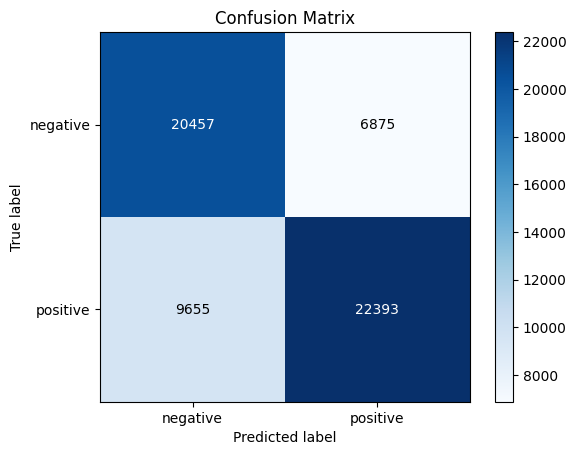

In [ ]:
skplt.plot_confusion_matrix(y_test ,predbow)


In [ ]:
print(classification_report(y_test ,predbow))


              precision    recall  f1-score   support

    negative       0.68      0.75      0.71     27332
    positive       0.77      0.70      0.73     32048

    accuracy                           0.72     59380
   macro avg       0.72      0.72      0.72     59380
weighted avg       0.73      0.72      0.72     59380



In [ ]:
print("Accuracy for Naive Bayes model with Bag of Words is ",round(accuracy_score(y_test ,predbow),3))

Accuracy for Naive Bayes model with Bag of Words is  0.722


**APPLYING NAIVE BAYES WITH tf-tdf**

Generating tf-idf (Team Frequency - Inverse Document Frequency) Vector matrix for Reviews



In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()

final_tfidf_count = tf_idf_vec.fit_transform(final_string)

from sklearn.preprocessing import StandardScaler

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count ) #mean=false implies data is sparse
#Transforms the text data into a TF-IDF representation where each row corresponds to a document, and each column corresponds to a unique word.

Splitting Data into Train and Test



In [ ]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = final_tfidf_np
y = final['Score']

X_train =  final_tfidf_np[:math.ceil(len(final)*.7)]
X_test = final_tfidf_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

Finding Optimal alpha Cross validation




The optimal alpha is  0.00021
the misclassification error for each k value is :  [0.269 0.269 0.269 0.269 0.269 0.269 0.269 0.269 0.269 0.269 0.269 0.269
 0.269 0.269 0.269 0.269 0.269 0.269 0.269 0.269]


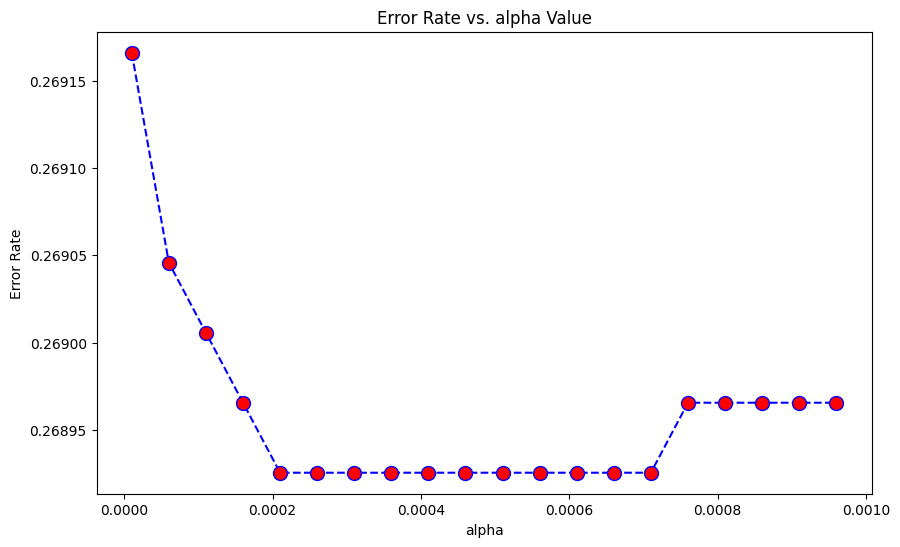

In [ ]:
from sklearn.naive_bayes import MultinomialNB
myList = np.arange(0.00001, 0.001, 0.00005)
optimal_alpha = find_optimal_k(X_train ,y_train,myList)  #Optimal value of alpha may differ through runs because of the randomness in the train_test_split process

Naive Bayes with Optimal alpha



In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha = optimal_alpha)
model = nb.fit(X_train, y_train)

In [ ]:
predtfidf = (model.predict(X_test))


In [ ]:
predtfidfprob = (model.predict_proba(X_test))

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

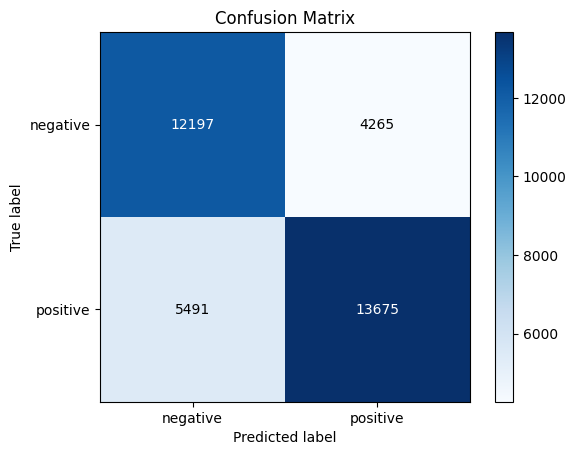

In [ ]:
skplt.plot_confusion_matrix(y_test ,predtfidf)

In [ ]:
print(classification_report(y_test ,predtfidf))

              precision    recall  f1-score   support

    negative       0.69      0.74      0.71     16462
    positive       0.76      0.71      0.74     19166

    accuracy                           0.73     35628
   macro avg       0.73      0.73      0.73     35628
weighted avg       0.73      0.73      0.73     35628



In [ ]:
print("Accuracy for Naive Bayes model with tf-id is ",round(accuracy_score(y_test ,predtfidf),3))

Accuracy for Naive Bayes model with tf-id is  0.726


**OBSERVATION**

At the end of the Analysis we have two Naive Bayes model to compare with different Feature generation techniques, one with BoW and second with tf-idf. By comparing accuracy of models it's clear that both the model have almost equal accuracy more than 72%